## Analysing the experimental data of  [Brydges et al, Science 2019](https://doi.org/10.1126/science.aau4963)

In [1]:
using Revise
using RandomMeas
using ProgressMeter

In [2]:
## parameters 
N = 10 # System size
times = [0,1,2,3,4,5] # quench times in ms
ntimes = length(times)  # number of time points
ξ = siteinds("Qubit", N); # site indices of the shadows

# Parameters specifying the Renyi entropies of interest
k_max = 6 # maximal Renyi index (n-th Renyi entropy)
NA_max = 6; #maximal subsystem size. We always consider subsystems of the form [1,2,...,NA].

We now load the experimental randomized measurement data obtained in Brydges et al., Science 2018.

In [3]:
data = Vector{MeasurementData}(undef, ntimes)

for s in 1:ntimes
    data[s] = import_measurement_data("BrydgesScience2019data/measurement_data_10_T_" * string(times[s]) * ".npz",site_indices=ξ, add_value = 1)
end 

┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measurement results contain now only Set([2, 1]) .
└ @ RandomMeas /Users/aelben/Andreas_Arbeit/Projects/RandomMeas.jl/src/MeasurementData.jl:115
┌ Warning: The add_value parameter is 1 and added to all measurement results. The measuremen

We estimate the purity using the direct purity estimation formula presented Brydges et al., Science 2019 and using classical shadows Huang et al., Nat. Phys. 2020.

In [4]:
p_direct = zeros(Float64,ntimes,NA_max)
p_shadow = zeros(Float64,ntimes,NA_max)
@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        p_direct[s,NA] = get_purity_direct(data[s],collect(1:NA))
        p_shadow[s,NA] = get_purity_dense_shadows(data[s],collect(1:NA))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


We estimate higher order Renyi entropies (up to order n) using batch shadows (c.f. Rath et al., PRXQ 2023). To do this for various subsystems, we can reduce the measurement data to the subsystem of interest, construct shadows for that and estimate the trace moments.

In [5]:
p_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        reduced_data = reduce_to_subsystem(data[s],collect(1:NA)) # reduce the data to the subsystem [1,2,...,NA]
        dense_shadows = get_dense_shadows(reduced_data; number_of_ru_batches = k_max ) # get the dense batch shadows for that subsystem
        p_bshadow[s,NA,:] = get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
        for k in 2:k_max
            S_bshadow[s,NA,k-1]= log2(p_bshadow[s,NA,k-1])/(1-k)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Alternatively, we can construct the shadows for the largest subsystem first, and then trace out qubits to restrict to smaller subsystems. This is slightly faster.

In [6]:
p_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
@showprogress for s in 1:ntimes
    data_NA_max = reduce_to_subsystem(data[s],collect(1:NA_max)) # reduce the data to the maximal subsystem [1,2,...,NA_max]
    dense_shadows = get_dense_shadows(data_NA_max; number_of_ru_batches = k_max ) # get the dense batch shadows for that maximal subsystem
    for NA in NA_max:-1:1
        dense_shadows = partial_trace(dense_shadows,collect(1:NA)) # reduce the batch shadows to the subsystem [1,2,...,NA]
        p_bshadow[s,NA,:] = get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Finally, we load quantum states generated by classical simulations (master equation evolution) of the experiment, including a decoherence model. We compute Renyi entropies.

In [50]:
using MAT

#TODO: Simplify this code

NA_max = 8

ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NA_max,k_max-1)
S = zeros(Float64,ntimes,NA_max,k_max-1)
SvN = zeros(Float64,ntimes,NA_max)
Salpha = zeros(Float64,ntimes,NA_max,501)

ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NA_max
        ξA = []
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]') 
            else
                push!(ξA,ξ[i])
            end
        end
        for nt in 2:k_max
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
        D, U  = eigen(ρA,inds(ρA,plev=0),inds(ρA,plev=1))
        SvN[s,NA] = get_entropy(D)
        for i in 1:501
            alpha = LinRange(1,6,501)[i]
            Salpha[s,NA,i] = get_entropy(D;alpha=alpha)
        end
    end
end

We plot the purity as a function of NA for the different times.

In [32]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NA_max,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NA_max,p_direct[s,:],"o",color=cm(s/ntimes))
    plot(1:NA_max,p_shadow[s,:],"x",color=cm(s/ntimes))
end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /Users/aelben/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (8,) and (6,)')
  File "/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/matplotlib/pyplot.py", line 3829, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/matplotlib/axes/_axes.py", line 1777, in plot
    lines = [*self._get_lines(self, *args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/matplotlib/axes/_base.py", line 297, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/matplotlib/axes/_base.py", line 494, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


We plot the higher order Renyi entropies as a function of Renyi index n for a fixed subystem size and various times.

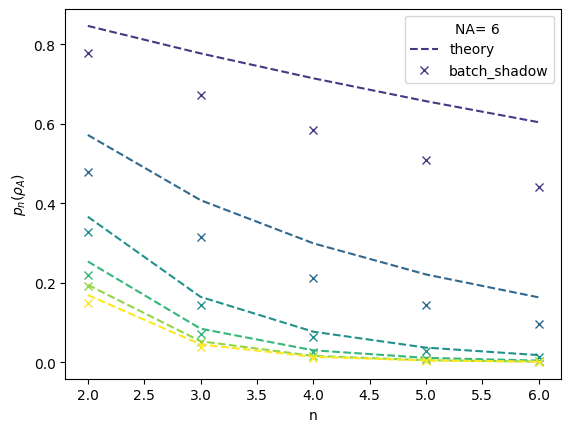

In [9]:
using PyPlot

clf()
cm = get_cmap(:viridis)
NA = 6
for s in 1:1
    plot(2:k_max,p[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot(2:k_max,p_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
end
for s in 2:ntimes
    plot(2:k_max,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:k_max,p_bshadow[s,NA,:],"x",color=cm(s/ntimes))
end
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()

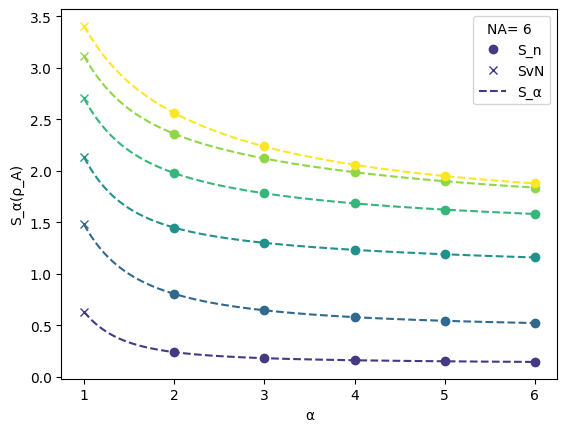

In [51]:
using PyPlot

clf()
cm = get_cmap(:viridis)
NA = 6
for s in 1:1
    plot(2:k_max,S[s,NA,:],"o",color=cm(s/ntimes),label="S_n")
    #plot(2:k_max,S_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
    plot(1,SvN[s,NA],"x",color=cm(s/ntimes),label="SvN")
    plot(LinRange(1,6,501),Salpha[s,NA,:],"--",color=cm(s/ntimes),label="S_α")
end
for s in 2:ntimes
    plot(2:k_max,S[s,NA,:],"o",color=cm(s/ntimes))
    #plot(2:k_max,S_bshadow[s,NA,:],"x",color=cm(s/ntimes))
    plot(1,SvN[s,NA],"x",color=cm(s/ntimes))
    plot(LinRange(1,6,501),Salpha[s,NA,:],"--",color=cm(s/ntimes))

end
xlabel("α")
ylabel("S_α(ρ_A)")
legend(title = "NA= $NA ")

gcf()

In [52]:
using NPZ

size(Salpha)

npzwrite("BrydgesScience2019data/RenyiAlphaEntropy_NumSim.npy", Salpha)

@show LinRange(1,6,501)

LinRange(1, 6, 501) = LinRange{Float64}(1.0, 6.0, 501)


501-element LinRange{Float64, Int64}:
 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, …, 5.95, 5.96, 5.97, 5.98, 5.99, 6.0

## Simulation of the experiment

In the following, we provide methods to simulate the Brydges experiment by loading the quantum states obtained from the Master equation simulation and performing randomized measurements on them.

In [7]:
using MAT
ITensors.disable_warn_order()

using LinearAlgebra
BLAS.set_num_threads(1)
using Base.Threads
println("Number of available threads: ", Threads.nthreads())

# Parameters
NU, NM = 500, 150

# times
times = [1,3,5] # quench times in ms

# Directory to save exported files
#export_dir = "MeasurementDataExports/"  # Directory to save exported files
export_dir = "/Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/"  # Directory to save exported files
isdir(export_dir) || mkpath(export_dir) # Ensure the export directory exists

# Samples
samples = 1000 # Number of times, we simulate the Brydges experiment with the same parameters 

@showprogress  for t in times
    # Load and process the quantum state
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(t)*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate, tuple((2 * ones(Int, 2 * N))...))
    rho = ITensor(qstate, vcat(ξ', ξ))
    rho = MPO(rho, ξ, cutoff=1e-10)

    @threads for sample in 101:100 + samples

        # Construct a meaningful filename
        filename = joinpath(export_dir, "simulated_measurement_data_t_$(t)_sample_$(sample)_NU_$(NU)_NM_$(NM).npz")

        if isfile(filename)
            continue
        end

        @show sample
        # Generate measurement settings and simulate results
        measurement_settings = RandomMeas.LocalUnitaryMeasurementSettings(N, NU, site_indices=ξ)
        measurement_data = simulate_local_measurements(rho, NM; mode="dense", measurement_settings=measurement_settings)



        # Export the data
        export_measurement_data(measurement_data, filename)
        println("Exported: $filename")

    end
end

Number of available threads: 8


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:29

sample = 325
sample = 1075
sample = 575
sample = 950
sample = 450
sample = 200
sample = 825
sample = 700
Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_950_NU_500_NM_150.npz
sample = 951
Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_825_NU_500_NM_150.npz
sample = 826
Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_325_NU_500_NM_150.npz
sample = 326
Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_450_NU_500_NM_150.npz
sample = 451
Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_575_NU_500_NM_150.npz
sample = 576
Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_200_NU_500_NM_150.npz
sample =

Progress: 100%|█████████████████████████████████████████| Time: 8:41:13


Exported: /Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/simulated_measurement_data_t_5_sample_225_NU_500_NM_150.npz


We load the data and estimate trace moments.

In [8]:
using LinearAlgebra
BLAS.set_num_threads(1)
using Base.Threads
println("Number of available threads: ", Threads.nthreads())

using NPZ

# Parameters
NU, NM = 500, 150

# times
times = [5] # quench times in ms

# Directory to save exported files
import_dir = "/Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/"  # Directory to save exported files

# Samples
samples = 1100 # Number of times, we simulate the Brydges experiment with the same parameters 

k_max = 6
NA_max = 6

p_bshadow = zeros(Float64,samples,length(times),NA_max,k_max-1)
S_bshadow = zeros(Float64,samples,length(times),NA_max,k_max-1)

for (s,t) in enumerate(times)

    @threads for sample in 1:samples

        @show sample

        filename = joinpath(import_dir, "simulated_measurement_data_t_$(t)_sample_$(sample)_NU_$(NU)_NM_$(NM).npz")

        loaded_data = import_measurement_data(filename, site_indices=ξ)

        data_NA_max = RandomMeas.reduce_to_subsystem(loaded_data,collect(1:NA_max)) # reduce the data to the maximal subsystem [1,2,...,NA_max]
        dense_shadows = RandomMeas.get_dense_shadows(data_NA_max; number_of_ru_batches = k_max ) # get the dense batch shadows for that maximal subsystem

        for NA in NA_max:-1:1
            dense_shadows = RandomMeas.partial_trace(dense_shadows,collect(1:NA)) # reduce the batch shadows to the subsystem [1,2,...,NA]
            p_bshadow[sample,s,NA,:] = RandomMeas.get_trace_moments(dense_shadows,collect(2:k_max)) # get the tracemoment from the batch shadows
            for k in 2:k_max
                S_bshadow[sample,s,NA,k-1]= log2(p_bshadow[sample,s,NA,k-1])/(1-k)
            end
        end

        filename = joinpath(import_dir, "simulated_renyi_estimates_t_$(t)_sample_$(sample)_NU_$(NU)_NM_$(NM).npz")


        npzwrite(filename, Dict("p_bshadow" => p_bshadow[sample,s,:,:], "S_bshadow" => S_bshadow[sample,s,:,:]))

    end
end

Number of available threads: 8
sample = 139
sample = 690
sample = 964
sample = 277
sample = 827
sample = 1
sample = 553
sample = 415
sample = 965
sample = 416
sample = 278
sample = 554
sample = 691
sample = 140
sample = 2
sample = 828
sample = 3
sample = 279
sample = 141
sample = 417
sample = 692
sample = 966
sample = 555
sample = 829
sample = 4
sample = 280
sample = 142
sample = 418
sample = 967
sample = 693
sample = 556
sample = 830
sample = 5
sample = 281
sample = 419
sample = 143
sample = 968
sample = 694
sample = 557
sample = 831
sample = 6
sample = 282
sample = 144
sample = 420
sample = 695
sample = 969
sample = 558
sample = 832
sample = 7
sample = 283
sample = 145
sample = 696
sample = 421
sample = 970
sample = 559
sample = 833
sample = 8
sample = 284
sample = 146
sample = 697
sample = 422
sample = 971
sample = 560
sample = 834
sample = 9
sample = 285
sample = 147
sample = 698
sample = 423
sample = 972
sample = 561
sample = 835
sample = 10
sample = 286
sample = 699
sample = 148


In [9]:
using LinearAlgebra
BLAS.set_num_threads(1)
using Base.Threads
println("Number of available threads: ", Threads.nthreads())

using NPZ

# Parameters
NU, NM = 500, 150

# times
times = [1,3,5] # quench times in ms

# Directory to save exported files
import_dir = "/Users/aelben/Data/RandomMeas_SampleBrydges/MeasurementDataExports/"  # Directory to save exported files

# Samples
samples = 1100 # Number of times, we simulate the Brydges experiment with the same parameters 

k_max = 6
NA_max = 6

p_bshadow = zeros(Float64,samples,length(times),NA_max,k_max-1)
S_bshadow = zeros(Float64,samples,length(times),NA_max,k_max-1)

for (s,t) in enumerate(times)

    @show t

    for sample in 1:samples


        filename = joinpath(import_dir, "simulated_renyi_estimates_t_$(t)_sample_$(sample)_NU_$(NU)_NM_$(NM).npz")

        loaded_data = npzread(filename)

        p_bshadow[sample,s,:,:] = loaded_data["p_bshadow"]
        S_bshadow[sample,s,:,:] = loaded_data["S_bshadow"]

    end
end

Number of available threads: 8
t = 1
t = 3
t = 5


In [12]:
npzwrite(joinpath(import_dir,"simulated_renyi_estimates.npz"), Dict("p_bshadow" => p_bshadow, "S_bshadow" => S_bshadow))

In [13]:
size(p_bshadow)

(1100, 3, 6, 5)